In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import timedelta
import sklearn
plt.style.use('seaborn')
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Analysis of Cycling Data

## Loading Data

The first dataset is an export of my ride data from [Strava](https://strava.com/), an online social 
network site for cycling and other sports.  This data is a log of every ride since the start of 2018
and contains summary data like the distance and average speed.  It was exported using 
the script `stravaget.py` which uses the stravalib module to read data. Some details of
the fields exported by that script can be seen in [the documentation for stravalib](https://pythonhosted.org/stravalib/api.html#stravalib.model.Activity). 

The exported data is a CSV file so that's easy to read, however the date information in the file is 
recorded in a different timezone (UTC) so we need to do a bit of conversion.  In reading the data I'm
setting the index of the data frame to be the datetime of the ride. 

In [2]:
strava = pd.read_csv('data/strava_export.csv', index_col='date', parse_dates=True)
strava.index = strava.index.tz_localize('UTC')
None

The second dataset comes from an application called [GoldenCheetah](https://www.goldencheetah.org/) which provides
some analytics services over ride data.  This has some of the same fields but adds a lot of analysis of the 
power, speed and heart rate data in each ride.  This data overlaps with the Strava data but doesn't include all 
of the same rides. 

Again we create an index using the datetime for each ride, this time combining two columns in the data (date and time) 
and localising to Sydney so that the times match those for the Strava data. 

In [3]:
cheetah = pd.read_csv('data/cheetah.csv', skipinitialspace=True)
cheetah.index = pd.to_datetime(cheetah['date'] + ' ' + cheetah['time'])
cheetah.index = cheetah.index.tz_localize('Australia/Sydney')
None

The GoldenCheetah data contains many many variables (columns) and I won't go into all of them here. Some
that are of particular interest for the analysis below are:

Here are definitions of some of the more important fields in the data. Capitalised fields come from the GoldenCheetah data
while lowercase_fields come from Strava. There are many cases where fields are duplicated and in this case the values
should be the same, although there is room for variation as the algorithm used to calculate them could be different
in each case. 

  * Duration - overall duration of the ride, should be same as elapsed_time
  * Time Moving - time spent moving (not resting or waiting at lights), should be the same as moving_time
  * Elevation Gain - metres climbed over the ride
  * Average Speed - over the ride
  * Average Power - average power in watts as measured by a power meter, relates to how much effort is being put in to the ride, should be the same as  * average_watts' from Strava
  * Nonzero Average Power - same as Average Power but excludes times when power is zero from the average
  * Average Heart Rate - should be the same as average_heartrate
  * Average Cadence - cadence is the rotations per minute of the pedals
  * Average Temp - temperature in the environment as measured by the bike computer (should be same as average_temp)
  * VAM - average ascent speed - speed up hills
  * Calories (HR) - Calorie expendature as estimated from heart rate data
  * 1 sec Peak Power - this and other  'Peak Power' measures give the maximum power output in the ride over this time period.  Will be higher for shorter periods. High values in short periods would come from a very 'punchy' ride with sprints for example.
  * 1 min Peak Hr - a similar measure relating to Heart Rate
  * NP - Normalised Power, a smoothed average power measurement, generally higher than Average Power 
  * TSS - Training Stress Score, a measure of how hard a ride this was
  * device_watts - True if the power (watts) measures were from a power meter, False if they were estimated
  * distance - distance travelled in Km
  * kudos - likes from other Strava users (social network)
  * workout_type - one of  'Race',  'Workout' or  'Ride'
  
  
Some of the GoldenCheetah parameters are defined [in thier documentation](https://github.com/GoldenCheetah/GoldenCheetah/wiki/UG_Glossary).  

## Your Tasks

Your first task is to combine these two data frames using the [`join` method of Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#joining-on-index).   The goal is to keep only those rows of data 
that appear in __both__ data frames so that we have complete data for every row.  

In [4]:
df = strava.join(cheetah,how='inner').dropna()
#only keep intresting columns mentioned before and remove no watt records
df = df[(df['Average Cadence']!= 0) & (df['device_watts'] == True)][['time','average_heartrate','average_temp','average_watts','device_watts','distance','elapsed_time','elevation_gain','kudos','moving_time','workout_type','Average Speed','Nonzero Average Power','Average Cadence','VAM','Calories (HR)','1 sec Peak Power','1 min Peak Hr','NP','TSS']]
df['elevation_gain'],df['time_hour'] = df['elevation_gain'].map(lambda x : float(x.replace(" m",''))),(pd.to_timedelta(df['time'],unit='m')).astype('timedelta64[m]')/60

## Cleaning

here i have cleaned the data, after inspecting the data later on in my analysis i realized there are quite a few feilds with data stacking up at 0 (or in the case of the temp reading from cheetah -255) i opted to prune these out of the data as they worsened my regression errors and dont seem to be real observations but instead missing values.

## Required Analysis

1. Remove rides with no measured power (where device_watts is False) - these are commutes or MTB rides
* Look at the distributions of some key variables: time, distance, average speed, average power, TSS. Are they normally distributed? Skewed? 
* Explore the relationships between the following variables. Are any of them corrolated with each other (do they vary together in a predictable way)? Can you explain any relationships you observe?  
    * Distance
    * Moving Time
    * Average Speed
    * Heart Rate
    * Power (watts)
    * Normalised power (NP)
    * Training Stress Score
    * Elevation Gain
* We want to explore the differences between the three categories: `Race`, `Workout` and `Ride`.
    * Use scatter plots with different colours for each category to explore how these categories differ.  
    * Use histograms or box plots to visualise the different distributions of a variable for the three categories.
    * In both cases, experiment with different variables but only include those that are interesting in your final notebook (if none are interesting, show us a representative example).


## Challenge

* What leads to more `kudos`? Is there anything to indicate which rides are more popular? Explore the relationship between the main variables and kudos. Show a plot and comment on any relationship you observe. 

* Generate a plot that summarises the number of km ridden each month over the period of the data. Overlay this with the _sum_ of the Training Stress Score and the _average_ of the Average Speed to generate an overall summary of activity.

* Generate a similar graph but one that shows the activity over a given month, with the sum of the values for each day of the month shown.  So, if there are two rides on a given day, the graph should show the sum of the distances etc for these rides.

Hint: to generate these summary plots you need to use the [timeseries/date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) in Pandas to generate a new data frame containing the required data.  

__Note:__ once you have completed these steps you can remove this cell.  Use the text as a starting point for the documentation of your workflow and discussion of results.


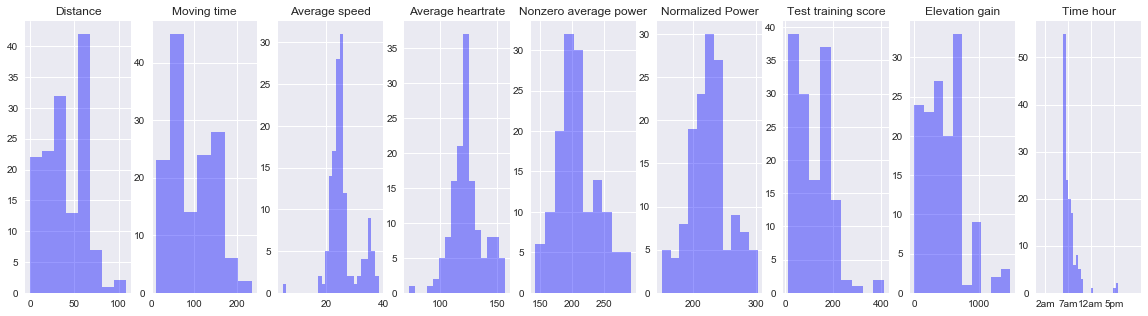

In [5]:
feilds = ['distance','moving_time','Average Speed','average_heartrate', 'Nonzero Average Power','NP', 'TSS','elevation_gain']
def beautifyName(name,newLine=False):
    res = ''
    if(name == 'NP'):
        res = 'Normalized Power'
    elif (name == 'TSS'):
        res = 'Test training score'
    else:
        res = name.replace("_"," ").capitalize()
    return res.replace(' ','\n') if newLine else res

fig, axArr = plt.subplots(1,len(feilds)+1,figsize=(20,5))
for key,ax in zip(feilds,axArr[:len(feilds)]):
    sns.distplot(df[key],kde=False,color=sns.saturate('b'),ax=ax).set_title(beautifyName(key))
    ax.set_xlabel(None)
    
sns.distplot(df['time_hour'],kde=False,ax=axArr[len(feilds)],color=sns.saturate('b')).set_title(beautifyName('time_hour'))
axArr[len(feilds)].set_xlabel(None),plt.xlim(0,23),plt.xticks([2,7,12,17],['2am','7am','12am','5pm'])
None

# Distribution of data  


## Zero Stacking
**Distance, Moving time, Test training score, Elevation gain and Time hour**
all seem to be stacked at 0.

## Non-normal Distrubutions
**Elevation gain and Test traing score** both do not seem to be normally distributed and **Normalized power, Moving time, Distance and Time hour** may well be non normall aswell but the case is weaker.

## Normal Distributions
**Average speed, Average heartrate and NZ Average power** all seem to be aproximatley normal however it is worth noting **average speed** seems bi-modal.


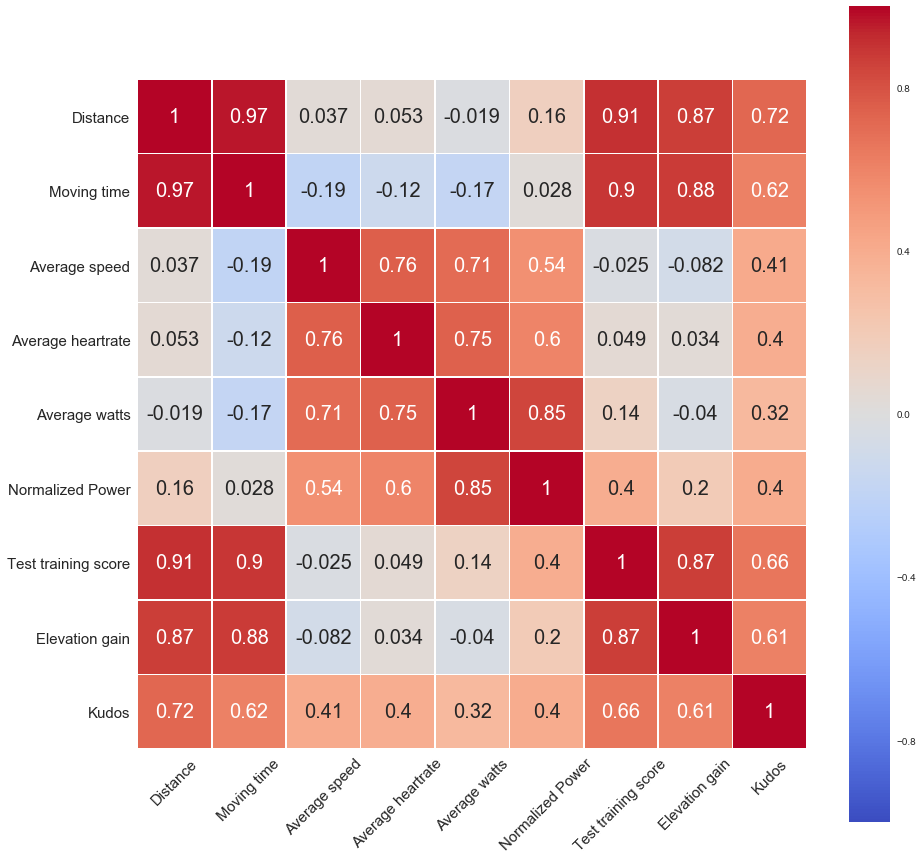

In [6]:
from matplotlib import colors as cols
corelCols = ['distance','moving_time','Average Speed','average_heartrate','average_watts','NP','TSS','elevation_gain','kudos']
correl = df[corelCols].corr()
fig, ax = plt.subplots(figsize=(15,15))
ax.tick_params(which='both', labelsize=15)
sns.heatmap(correl,ax=ax, cmap='coolwarm',square=True, annot=True, annot_kws={"size": 20},linewidths=.5,center=0, vmin=-1, vmax=1)
ax.set_xticklabels([beautifyName(e) for e in corelCols],rotation=45),ax.set_yticklabels([beautifyName(e) for e in corelCols])
None

# Correlation
<br/>

above is a "corelation" matrix.

simply white squares represent no correlation, red represent positive and blue negative, the stronger the colour the stronger the correlation

this is done via [linear regression](https://en.wikipedia.org/wiki/Linear_regression) <br/><br/>

note the strong red on the diagonals is only there as "somevalue" will allways correlate 1:1 with itself

typicaly .25 is considerd a weak correaltion .5 moderate and .75 verry strong

it is importnant to note that some of these correaltions may be trivial observations or tell us verry little

One thing that initally stands out is **Distance** and **Moving time** have a near perfect correaltion but this makes sense if the rider takes similar routes and/or rides at the same speed consitently and and a result the correaltions for these 2 rows are almost identical for all other variables

Other than that there are a hand full of red squares that all show clusters of variables that all have correlations woith one another and it is worth noting all of the negative correlations (showin in blue) are all quite weak.

In [7]:
import numpy as np
def getRowCorrel(key):
    fig, ax = plt.subplots(figsize=(20,20))
    row = pd.DataFrame([correl[key]]).drop(key,axis='columns')
    mat = ax.matshow(row,cmap='coolwarm', norm =cols.Normalize(-1,1))
    plt.xticks(range(row.shape[1]), [beautifyName(e) for e in row.columns.values], fontsize=20, rotation=45)
    plt.grid(b=None)
    plt.yticks([])
    plt.ylabel(beautifyName(key,True),fontsize=20,rotation=0,labelpad=50)
    for (i, j), z in np.ndenumerate(row):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',fontsize =20)
    plt.show()

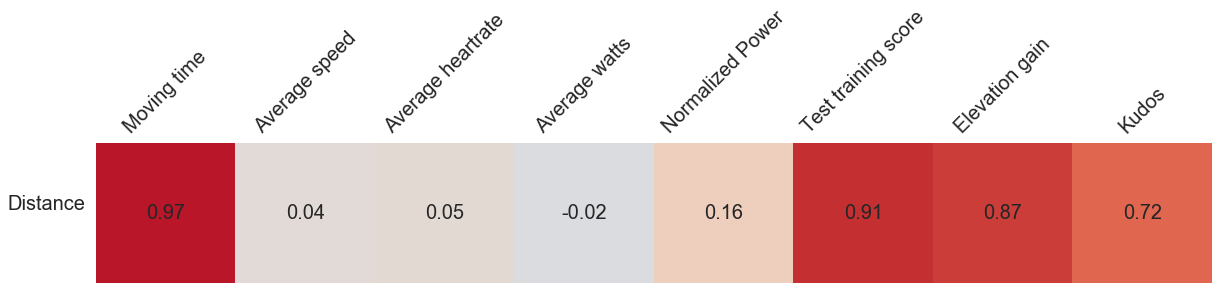

In [8]:
getRowCorrel('distance')

## Distance

here we can see distance has a strong correlaton with moving time and elapsed time (to be expected)

aswell as a strong correlation with kudos witch is a much more intresting observation as it isnt obviously dependant on time

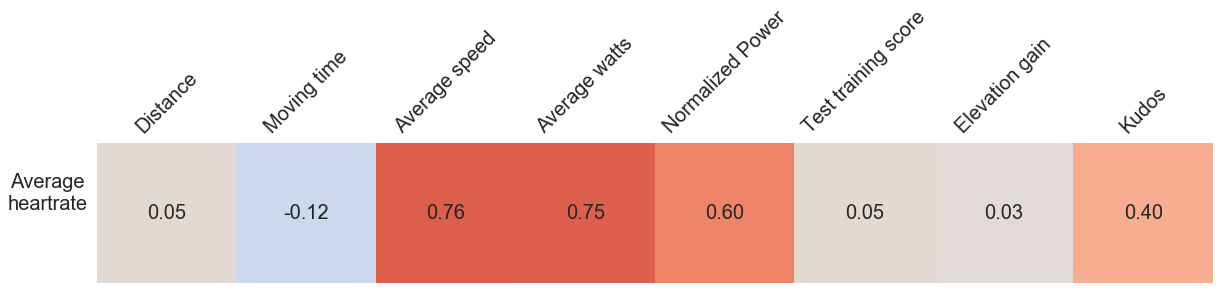

In [9]:
getRowCorrel('average_heartrate')

## Heart rate

Heartrate has a moderate correlation with average watts aswell as a weaker one with kudos

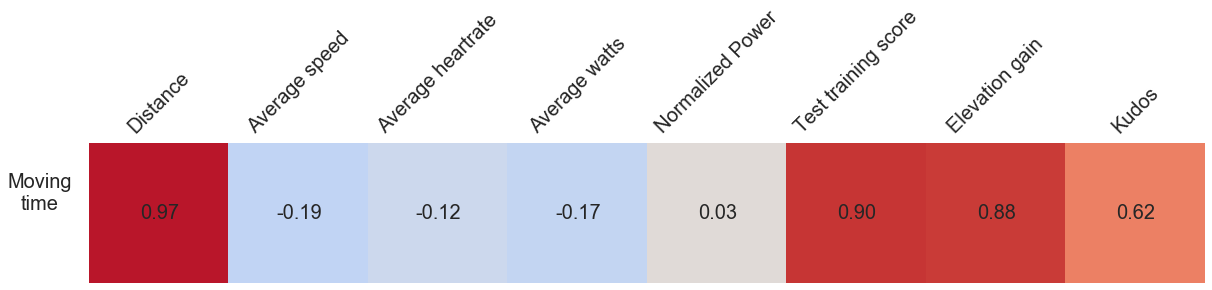

In [10]:
getRowCorrel('moving_time')

## Moving time

moving time has a strong correlation with **Distance** and **Elapsed Time**

more intrestingly it has a correlation with **Kudos** however it is not as strong 

additionally it has some weak negative corelations with **Average (Speed/HeartRate/Watts)**

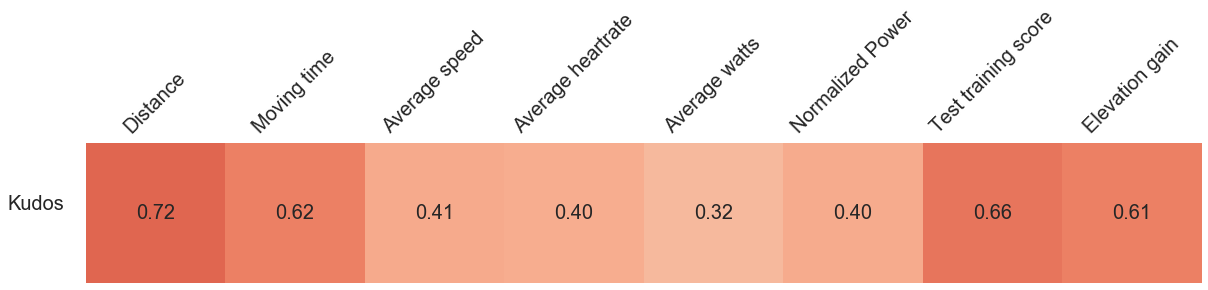

In [11]:
getRowCorrel('kudos')

## Kudos

Intestingly Kudos has a moderate to strong positive correlaion with almost all of the variables the strongest being **Distance** and weakest being **Average Watts**

## Workout Types

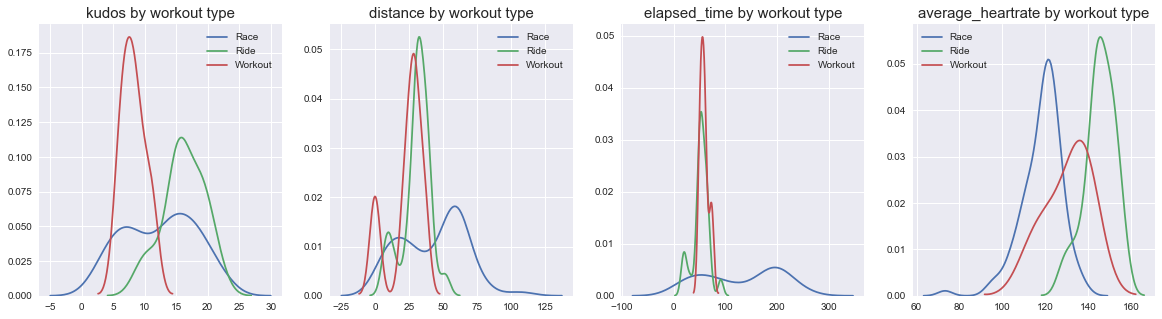

In [12]:
ride,race,workout = df[df['workout_type'] == 'Ride'],df[df['workout_type'] == 'Race'],df[df['workout_type'] == 'Workout']
workoutGroups,names = [ride,race,workout], ['Race','Ride','Workout']

def plotMulti(subSets,names,feild,ax=None):
    for item,name in zip(subSets,names):
        sns.kdeplot(item[feild],label=name,ax=ax)
    ax.set_title(f"{feild} by workout type",fontsize=15)

fig, axArr = plt.subplots(1,4,figsize=(20,5))
plotMulti(workoutGroups,names,'kudos',axArr[0])
plotMulti(workoutGroups,names,'distance',axArr[1])
plotMulti(workoutGroups,names,'elapsed_time',axArr[2])
plotMulti(workoutGroups,names,'average_heartrate',axArr[3])
None

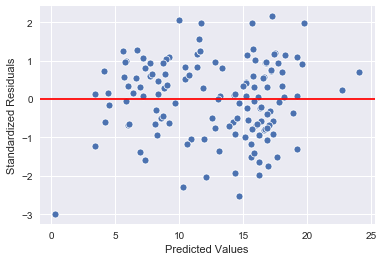

 Mean Squared Error: 8.45613162774559
 Root Mean Squared Error: 2.907942851526761
 Colums Kept:
  Average temp
  Distance
  Elapsed time
  Moving time
  Average speed
  Nonzero average power
  Average cadence
  Time hour


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import math
#its worth noting i am traning and testing on the same data here

estimator = sklearn.linear_model.LinearRegression()
predictors = df[[x for x in df._get_numeric_data().columns.values if x != 'kudos']]
selector = sklearn.feature_selection.RFE(estimator,step=1)
selector = selector.fit(predictors,df['kudos'])

predicted = selector.predict(predictors)
residuals = predicted -df['kudos']
mse =  (residuals  ** 2).sum()/len(residuals)
rmse = math.sqrt(mse)
supportCols,prunedCols = predictors.columns.values[selector.support_],predictors.columns.values[~selector.support_]

residualScaler = StandardScaler()
residualScaler = residualScaler.fit(pd.DataFrame({'data':residuals}))
sns.scatterplot(predicted,residualScaler.transform([residuals])[0])
plt.ylabel("Standardized Residuals")
plt.xlabel("Predicted Values")
plt.title = 'Residual Plot'
plt.axhline(color='r')
plt.show()
nl = '\n  '
print(f' Mean Squared Error: {mse}\n',
      f'Root Mean Squared Error: {rmse}\n',
      f"Colums Kept:{nl}{nl.join(beautifyName(e) for e in supportCols)}")

In [14]:
#kept = sns.pairplot(df,x_vars=supportCols,y_vars='kudos',kind='reg').fig.suptitle("Kept Predictors",size=30,y=1.15)
#pruned = sns.pairplot(df,x_vars=prunedCols,y_vars='kudos',kind='reg').fig.suptitle("Pruned Predictors",size=35,y=1.15)
#None
df.columns.values
labels = ["hi-myname","jee-ff"]
nl = "\n"
l2 = [e.replace("-","\n") for e in labels]

for e in l2:
    print(e)
    print("---")

hi
myname
---
jee
ff
---


## Kudos
#### bonus question

Here i opted to use a linear regression model with RFE to prune predictors that had a poor predictive value
it yelded a model that had a  Mean Squared Error of 8.4 and a Root Mean Squared Error of 2.9

for this i also included the scatter plots so one can eyball if the correlations seem to make sense one that stands out is **Time hour** as it seems that the correlation has been fit incorectly and at the verry least a worse fit than say **Calories** however it may be the case that in the higer dementional space it helps reduce over or under prediction that other feilds introduce

In [15]:
completePath = "data/energydata_complete.csv"
trainingPath = "data/training.csv"
testingPath = "data/testing.csv"

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
df = pd.read_csv(completePath)

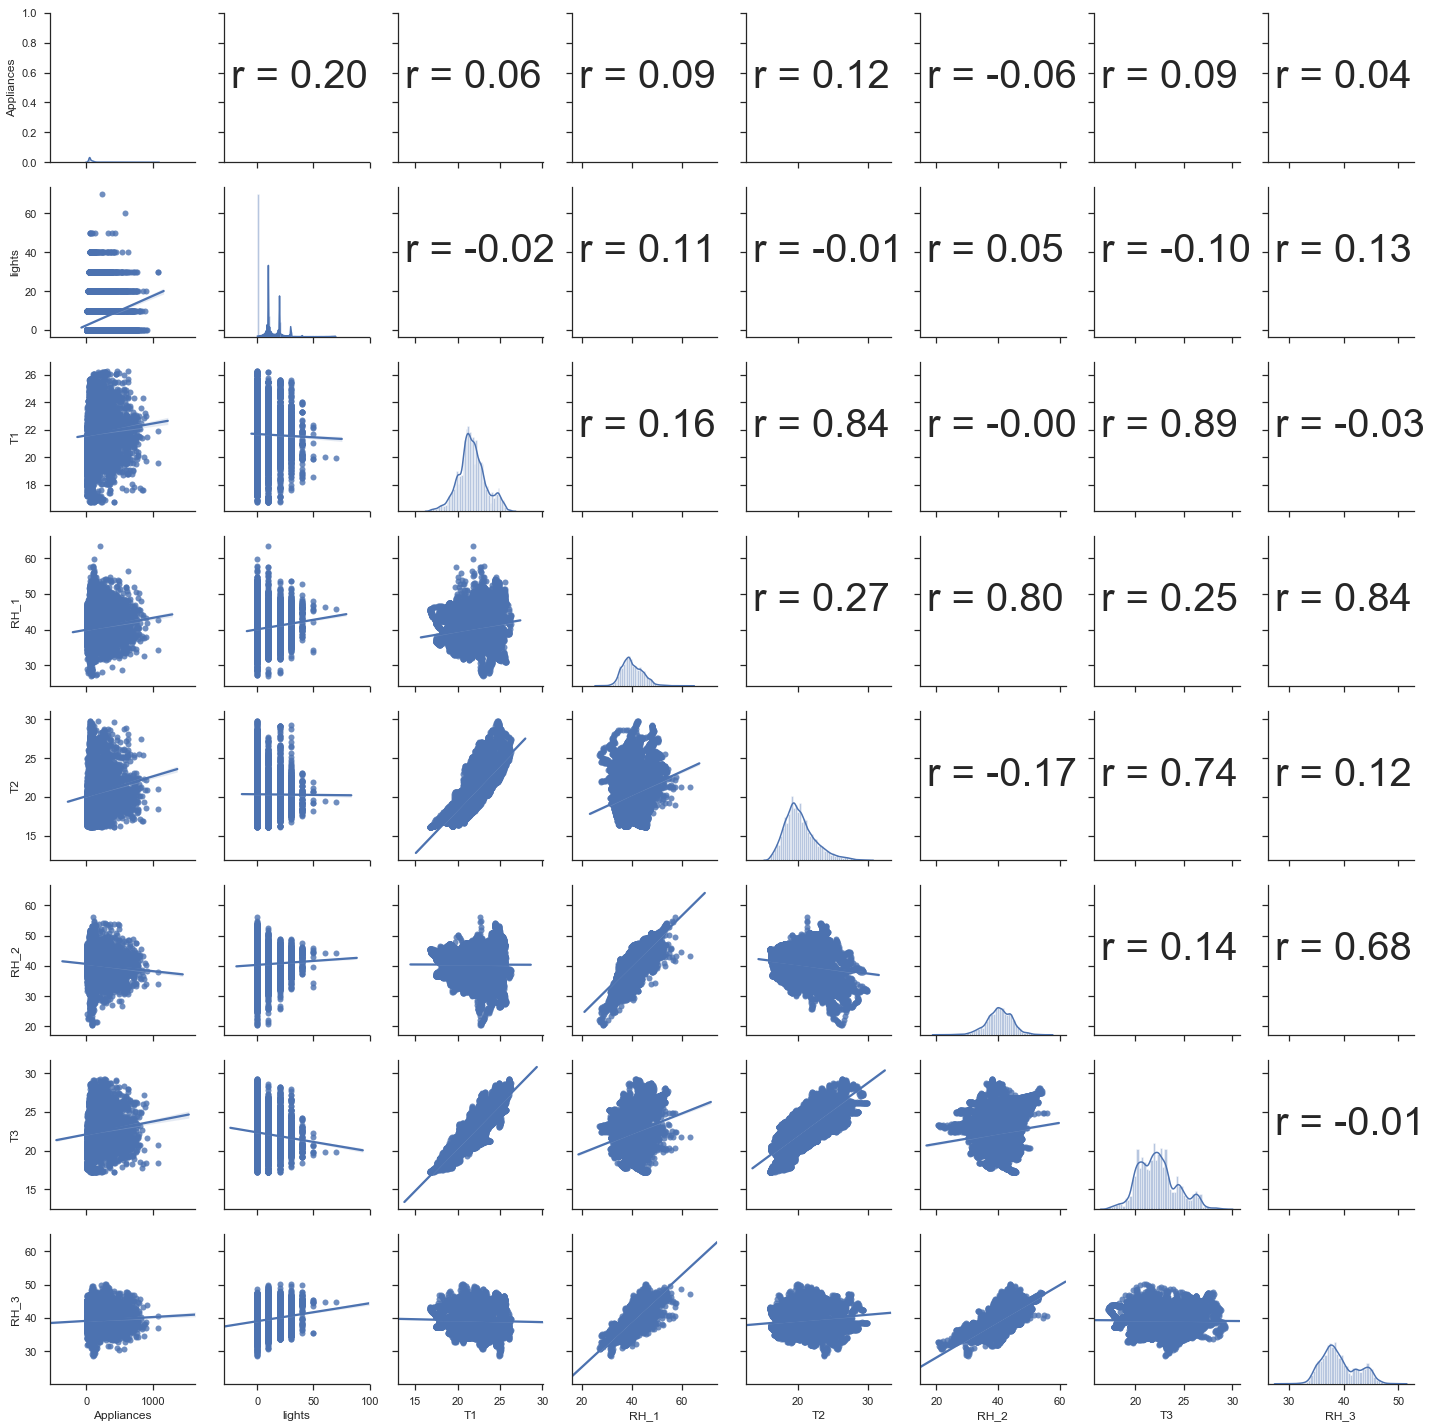

In [18]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),xy=(0.05, .5), xycoords=ax.transAxes,size=40)

sns.set(style="ticks", color_codes=True)
pairp = sns.PairGrid(df,vars=['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3','RH_3'])
pairp.map_diag(sns.distplot),pairp.map_lower(sns.regplot),pairp.map_upper(corrfunc)
None

## Pairs plot reproduction

Here i have tried to recreate the exact plot from the paper with some custom code. I had to add in the numeric correlation values aswell as the scatter + line of best fit plots using seaborns "Pairgrid" function.

All the plots and correlation coefficients look the same as the paper

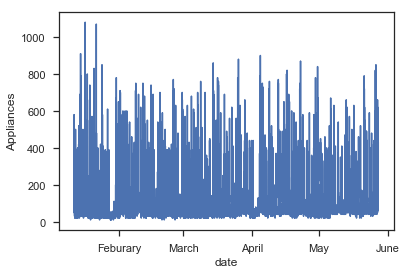

In [19]:
df['date'] = pd.to_datetime(df['date'])
dayMap = dict(zip([6]+list(range(0,6)),range(0,7))) #so the 1st day is sunday not monday
monthNames = ['January', 'Feburary', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['week'],df['day'],df['hour'],df['month'] = df['date'].map(lambda x: x.isocalendar()[1]) ,df['date'].map(lambda x: dayMap[x.weekday()]) ,df['date'].map(lambda x: x.hour),df['date'].map(lambda x: x.month)
df = df.sort_values('date')
ticks = [pd.datetime(2016,e,1,0) for e in range (2,7)]
mLine = sns.lineplot(df['date'],df['Appliances'])
mLine.set_xticks(ticks),mLine.set(xticklabels=[monthNames[e.month-1] for e in ticks]) #-1 so that the tick represents the END of the month,mLine.set(xlim =(pd.datetime(2016,1,1,0), pd.datetime(2016,6,1,0)))
None

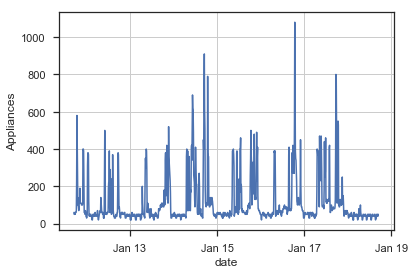

In [20]:
wLine = sns.lineplot(df['date'][1:1008],df['Appliances'][1:1008])
ticks = [pd.datetime(2016,1,13 + e,0) for e in range (0,8,2)]
wLine.set_xticks(ticks),wLine.set(xticklabels=["Jan " + str(e.day) for e in ticks]),wLine.grid(True)
None

## Appliance energy consumption lineplots

Here i had to take the appliance energy and plot it over time, this took me a while to figure out they where labeling the date ticks differently than the python default. In order to remedy this i had to make the ticks line up with the end of the month.

after this i did the 1 day plot and realised just setting the start-end range to the days specified in the paper would give me incorrect results, instead i had to use the exact array slice its woth noting that this may mean that the graph in the paper isnt quite matching up with its label.

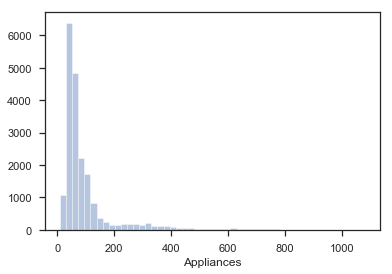

In [21]:
sns.distplot(df['Appliances'], kde=False)
None

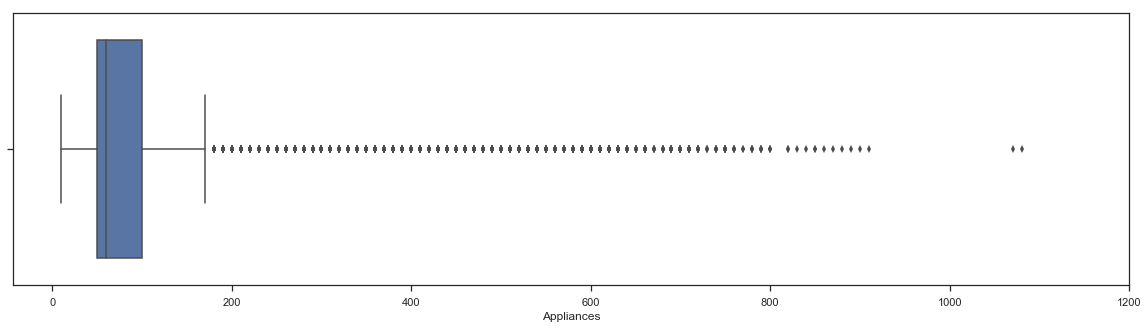

In [22]:
fig,ax = plt.subplots(figsize=(20,5)),sns.boxplot(df['Appliances']).set_xticks(range(0,1201,200))
None

## Distribution plots

Next i had to reproduce both the histogram and box plot for the distribution of the appliance energy consumption feild my results look the same as the paper and this one was straightfoward.

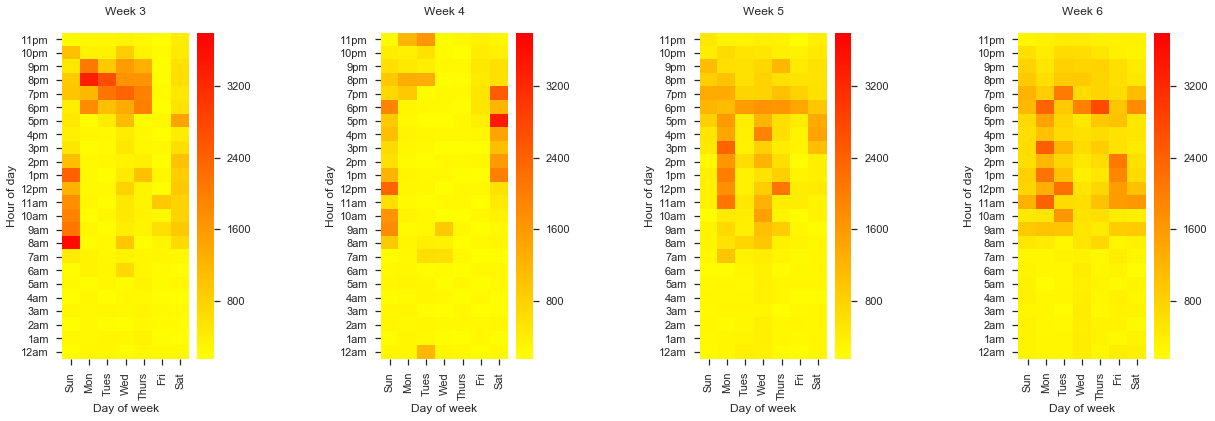

In [23]:
hourLables = (["12am"] + [str(e)+"am"  for e in range(1,12)] + ["12pm"] + [str(e)+"pm"  for e in range(1,12)])[::-1]
dayNames = ['Sun','Mon','Tues','Wed','Thurs','Fri','Sat']

weeks = range(3,7)
fig, axArr = plt.subplots(1,len(weeks),figsize=(20,6), gridspec_kw=dict(wspace=1))
for week,ax in zip(weeks,axArr):
    pivot = pd.pivot_table(df[df['week'] == week] [['day','hour', 'Appliances']], index=['day', 'hour'], aggfunc='sum')
    unstacked = pivot.unstack(level=0)
    ax = sns.heatmap(unstacked.sort_index(ascending=False), fmt="d", ax=ax,cmap='autumn_r',vmin=150, vmax=3800,xticklabels=dayNames,yticklabels=hourLables)
    ax.axes.set_title(f"Week {week}\n")
    ax.set(xlabel='Day of week', ylabel='Hour of day');
plt.show()

## Hourly usage heatmap

here i took the first 4 weeks (3-6) and i created a heatmap for each week, i had to dig around the R notebook to reproduce this properly, the hardwired heat map max/min are taken directly from it aswell as the weeks.
<br><br>
Its worth noting that the week 6's heatmap seems visually different as it has an "L" shape at Fri/Sat at around midday where was the paper does not, i took some time to ensure i was sampling correctly and came to the conclusion that it was due to differing gradients as i have the same timestamps and week selected in that heatmap.

Total number of features: 28

Optimal features: 27


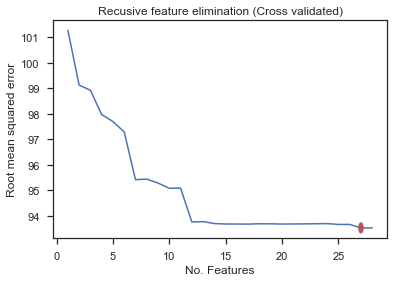

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from matplotlib.patches import Circle

import math

dateToInt = dict(zip(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"], range(0,7)))

def makeNumeric(df):
    df['WeekStatus'] = df['WeekStatus'].map(lambda x : 0 if x is "Weekend" else 1)
    df['Day_of_week'] = df['Day_of_week'].map(lambda x: dateToInt[x])
    return df

df_train, df_test = pd.read_csv(trainingPath).drop(['rv1','rv2'],axis=1),pd.read_csv(testingPath).drop(['rv1','rv2'],axis=1)
#remove random variables as our models shouldn't use them
df_train, df_test = makeNumeric(df_train), makeNumeric(df_test)
df_train_test = pd.concat([df_train , df_test])

predictors = df_train_test._get_numeric_data().drop(['Appliances'], axis=1)
print(f"Total number of features: {predictors.columns.values.size}\n")


split = [(range(0,len(df_train)),range(len(df_train),len(df_train) + len(df_test)))]

def RMSE(estimator, X, y):
    return(math.sqrt(np.mean( (y - estimator.predict(X)) ** 2)))
        
def residPlot(predictors,y,model):
    y_hat = model.predict(predictors)
    residuals = y - y_hat
    sns.scatterplot(y,residuals)
    plt.ylabel("Residuals")
    plt.xlabel("Appliances Energy Consumption")
    plt.title = 'Residual Plot'
    plt.axhline(color='r')
    
def trainReduced(pred,y): 
    return RFECV(LinearRegression(),step=1,scoring=RMSE,cv=split).fit(pred,y)

model =trainReduced(predictors,df_train_test['Appliances'])

sns.lineplot(range(1,len(model.grid_scores_) + 1),model.grid_scores_).set_title('Recusive feature elimination (Cross validated)')
plt.ylabel("Root mean squared error")
plt.xlabel("No. Features")
minError = np.argmin(model.grid_scores_) + 1;
print(f"Optimal features: {minError}")
plt.gcf().gca().add_artist(Circle((minError,model.grid_scores_[minError -1]),0.2,color='r')) ## add blip for min error
plt.show()
None

## Recursive feature elimination and cross validation

Following the paper i implemented feature elimination with "cross validation".I opted to use linear regression as my model due to the residuals and results better matching the paper.

The data was not initally ready for RFE, first i had remove the "random variables" (rv1 and rv2), I then had to convert the "weekday" and "day of week" columns to numeric vales. I achived this by making a MakeNumeric() function. 

After this i printed out the amount of features and realized i didnt have the same amount as the paper but after some playing around with the data i opted to leave out the random variables as in the R note book the researchers did the same and my resuts where closer with them in.


After doing this i utilized [sklearns](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) RFECV fucntion, i specified i wanted my own custom Root mean squared error function aswell as telling it to use the provided train/test split the rearchers had used, i achived this by combining the 2 dataframes then specifying what indexs belonged to what tuple. this resulted in only 1 cross validation but i felt this was aproprate as splitting into more bags would have caused my results to vary.

Its worth noting here that my results didnt exactly match the paper but i belive it was due to me not having the same amount of features.

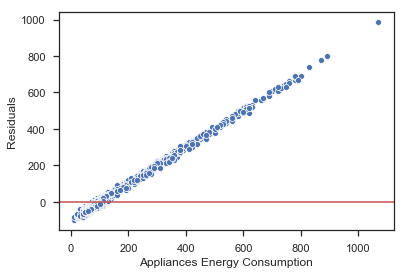

In [25]:
residPlot(df_test.drop(['Appliances'],axis=1)._get_numeric_data(),df_test['Appliances'],model)
None

## Residual plot

Once i had my reduced features i used my model to produce the residuals. I plotted them vs the appliance energy consumption, here my plot matches the paper quite well even down to the outlier in the top right however the points seem to be more tightly bound to the line.

its worth noting that their is no "Curve" in the residual plot leading us to belive that linear regression is a good model for this data.

# Portfolio 3 - Clustering Visualisation

K-means clustering is one of the simplest and popular unsupervised learning algorithms. Typically, unsupervised algorithms make inferences from datasets using only input vectors without referring to known, or labelled, outcomes. This notebook illustrates the process of K-means clustering by generating some random clusters of data and then showing the iterations of the algorithm as random cluster means are updated. 

We first generate random data around 4 centers.

In [26]:
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

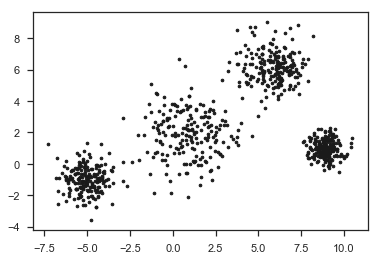

In [27]:


# Generate random data and center it to the four centers each with a different variance
center_1,center_2,center_3,center_4 = np.array([1,2]),np.array([6,6]),np.array([9,1]),np.array([-5,-1])
np.random.seed =5
data_1,data_2,data_3,data_4 = np.random.randn(200,2) * 1.5 + center_1,np.random.randn(200,2) * 1 + center_2,np.random.randn(200,2) * 0.5 + center_3,np.random.randn(200,2) * 0.8 + center_4
data = np.concatenate((data_1, data_2, data_3, data_4), axis = 0)
plt.scatter(data[:,0], data[:,1], s=7, c='k')
plt.show()

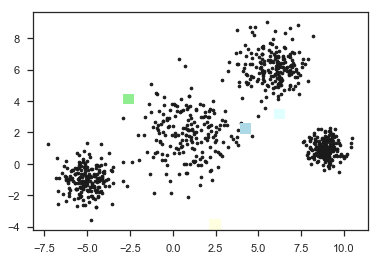

In [28]:
cols =['green', 'blue', 'yellow', 'cyan']

def showCenters(centers):
    for p,c in zip (centers,cols):
        plt.gcf().gca().add_artist(Rectangle((p[0],p[1]),0.6,0.6,color="light"+c))
        
def moveClusters(points,clusters): 
    return np.array([np.array([p for e_c,p in (zip(clusters ,points)) if e_c == c]).mean(axis=0) for c in range(0,k)])
                       
def getClosestCent(point,centroids):
    arr = [np.linalg.norm(point-c) for c in centroids]
    return arr.index(min(arr))

def reassignPoints(centers):
    return np.array([getClosestCent(e,centers) for e in data])
  
def stepKMeans(centers,cluster):
    newCents = moveClusters(data,cluster)
    return reassignPoints(newCents),newCents

def showSimple(centers):
    showCenters(centers)
    sns.scatterplot(x =data[:,0], y=data[:,1],hue=clusters,palette=cols[:np.unique(clusters).size],edgecolor='r',linewidth=0.5)
    plt.tick_params(axis='both', which='both', bottom=False, left=False,labelbottom=False,labelleft=False) 
    plt.xlabel(None)
    plt.ylabel(None)
    plt.show()

k,c,np.random.seed = 4,2,6
centers = np.random.randn(k,c)*np.std(data) + np.mean(data)

while len(np.unique(reassignPoints(centers))) != 4: #this is to catch the edge case where a cluster has 0 points
    centers = np.random.randn(k,c)*np.std(data) + np.mean(data)

plt.scatter(data[:,0], data[:,1], s=7, c='k')
showCenters(centers)
plt.show()

## Cluster Generation

Most of the cluster generation is self explanitory but i had to add a loop in to ensure that the randomness dont not permit a cluster with 0 points in it, this would cause a bug later in my program. While setting the seed should fix this for some reason it does not.

## K-Means Implemenation

above i have implemented a verry simple k-means algorithim. while real wold aplications typicaly include random initalization, comparing of multiple runs aswell as measures to reduce the distance calculations such as [K-Trees](https://en.wikipedia.org/wiki/K-tree).

my algorithim as 2 parts;

1. Relocate every cluster to the center of all points contained within it (the average), i do so in a function called "MoveClusters", it simply makes K arrays coresponding to each vector then it takes the average point.
2. Reassign points based on what cluster "centeroid()" is closest, this is done in a function called "reassignPoints()" it simply passes every point to a function called "getClosestCent()" that will return the index (also the cluster name) of the closest cluster center.

once these where completed all i had to do is run MoveClusters() then MoveCents() for 1 iteration of the algorithim.

along with this i have made some auxilary functions to make both display simpler, such as the ability to draw the centers.

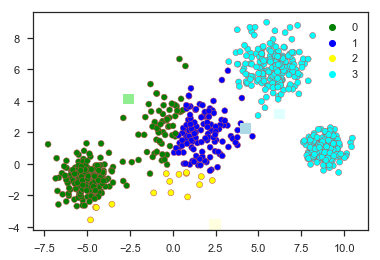

In [29]:
clusters = reassignPoints(centers)
sns.scatterplot(x =data[:,0], y=data[:,1], hue=clusters,palette=cols[:np.unique(clusters).size],edgecolor='r',linewidth=0.5)
showCenters(centers)
None

In [30]:
plt.title('First 5 Itterations')
currCenter = centers
for i in range(0,5):
    clusters, currCenter = stepKMeans(currCenter,clusters)
    showSimple(currCenter)             
None

TypeError: 'str' object is not callable

In [ ]:
plt.title('10 Step Increments')
for i in range(0,5):
    for step in range(0,10):
        clusters,currCenter = stepKMeans(currCenter,clusters)
    showSimple(currCenter)
None